<a href="https://colab.research.google.com/github/rafaxy/tarefas_AI/blob/main/tarefa_trash_bin_AI_tentativa_2_chatgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner
!pip install -q gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import gdown
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import Hyperband
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Download the zip file
url = 'https://drive.google.com/uc?id=1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX'
output = 'trash_nov_22_2018.zip'
gdown.download(url, output, quiet=False)

# Extract the zip file
with zipfile.ZipFile('trash_nov_22_2018.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

Downloading...
From: https://drive.google.com/uc?id=1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX
To: /content/trash_nov_22_2018.zip
100%|██████████| 42.8M/42.8M [00:01<00:00, 39.9MB/s]


In [ ]:
# Create a list of categories
categories = ['trash', 'metal', 'paper', 'plastic', 'glass', 'cardboard']

# Create a list to store images and labels
images = []
labels = []

# Load and preprocess the images
for category in categories:
    for file_name in os.listdir('dataset'):
        if file_name.startswith(category):
            img = load_img(f'dataset/{file_name}', target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)


# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

from sklearn.preprocessing import LabelBinarizer

# One-hot encode the labels
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

# Now your labels are one-hot encoded, so you can split them into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                     activation='relu',
                     input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                    activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=10,
                  directory='output',
                  project_name='TrashClassifier')


In [ ]:
# Search for the best model
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Print the performance results for each model as they are being tested
for key in history.history.keys():
    print(key, ' : ', history.history[key])


Trial 30 Complete [00h 01m 25s]
val_accuracy: 0.24703557789325714

Best val_accuracy So Far: 0.3853754997253418
Total elapsed time: 00h 17m 15s
Epoch 1/10
64/64 [==============================] - 6s 64ms/step - loss: 190.1856 - accuracy: 0.2202 - val_loss: 1.7518 - val_accuracy: 0.2213
Epoch 2/10
64/64 [==============================] - 4s 61ms/step - loss: 1.6332 - accuracy: 0.3187 - val_loss: 1.9678 - val_accuracy: 0.2352
Epoch 3/10
64/64 [==============================] - 4s 57ms/step - loss: 1.6078 - accuracy: 0.3256 - val_loss: 1.9158 - val_accuracy: 0.1937
Epoch 4/10
64/64 [==============================] - 4s 56ms/step - loss: 1.2333 - accuracy: 0.4928 - val_loss: 2.4331 - val_accuracy: 0.2609
Epoch 5/10
64/64 [==============================] - 4s 61ms/step - loss: 0.8456 - accuracy: 0.6705 - val_loss: 3.4300 - val_accuracy: 0.3024
Epoch 6/10
64/64 [==============================] - 4s 58ms/step - loss: 0.7451 - accuracy: 0.7432 - val_loss: 3.0850 - val_accuracy: 0.3024
Epoch 7/

16/16 [==============================] - 1s 29ms/step


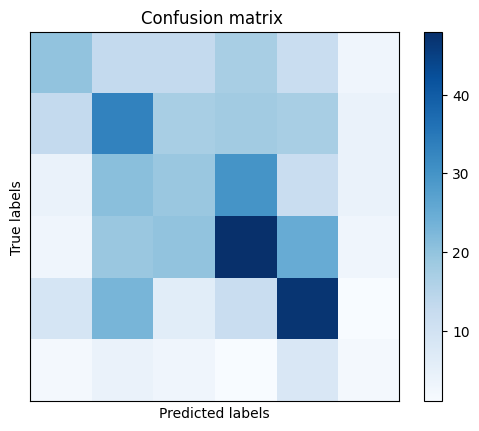

[[20 13 13 17 12  3]
 [13 33 17 18 17  4]
 [ 4 21 19 30 12  4]
 [ 3 19 20 48 25  3]
 [ 9 23  6 12 47  1]
 [ 2  4  3  1  8  2]]
           trash  metal  paper  plastic  glass  cardboard
trash         20     13     13       17     12          3
metal         13     33     17       18     17          4
paper          4     21     19       30     12          4
plastic        3     19     20       48     25          3
glass          9     23      6       12     47          1
cardboard      2      4      3        1      8          2


In [ ]:
#You can convert y_test from one-hot encoded to label encoded using numpy.argmax function, which will return the
#index of the maximum value from each row (in this case, the index refers to the class). Here is how you can do it:
y_test_labels = np.argmax(y_test, axis=1)
# Get the predictions
y_pred = model.predict(X_test)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
print(cm)
import pandas as pd

categories = ['trash', 'metal', 'paper', 'plastic', 'glass', 'cardboard']  # Replace with your categories

confusion_df = pd.DataFrame(cm, index=categories, columns=categories)

print(confusion_df)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- conv_1_filter: {best_hps.get('conv_1_filter')}
- conv_1_kernel: {best_hps.get('conv_1_kernel')}
- conv_2_filter: {best_hps.get('conv_2_filter')}
- conv_2_kernel: {best_hps.get('conv_2_kernel')}
- dense_1_units: {best_hps.get('dense_1_units')}
""")



Best hyperparameters:
- conv_1_filter: 48
- conv_1_kernel: 3
- conv_2_filter: 64
- conv_2_kernel: 3
- dense_1_units: 32

